# Precificando Jogadores de Futebol

# Coleta de dados
Nesta seção iremos coletar os dados por meio de web scraping e apis de outros sites

In [215]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
prefix = 'https://www.transfermarkt.com'
def getSoup(url):
    res = requests.get(url, headers = headers)
    return BeautifulSoup(res.content, 'html.parser')


### Função para realizar o web scraping das tableas de transferências no transfermarkt

In [163]:
import re

def getClubUrl(url):
    url = url.replace('/transfers', '')  # Remove a substring '/transfers'
    match = re.search(r'/verein/(\d+)', url)
    verein_id = match.group(1)  # Obtém o número após "/verein/"
    new_url = match.string[:match.start()] + '/startseite' '/verein/' + verein_id
    return new_url
    

def eurValue(string):
    padrao = r'^€.*[mk]$'  # Expressão regular para verificar se começa com '€' e termina com 'm' ou 'k'
    if re.match(padrao, string):
        return True
    else:
        return False

def eurToInt(string):
    valor_str = re.sub(r'[€mk]', '', string)  # Remove '€', 'm' e 'k' da string
    valor_float = float(valor_str.replace(',', '.'))  # Substitui a vírgula pelo ponto como separador decimal e converte para float
    if 'm' in string:
        valor_int = int(valor_float * 1000000)  # Converte para milhões
    elif 'k' in string:
        valor_int = int(valor_float * 1000)  # Converte para milhares
    else:
        valor_int = int(valor_float)
    return valor_int

def getTransfersFromUrl(url, year):
    transferTable = []
    page = getSoup(url.format(year))
    tables = page.find_all('div', {'class': 'box'})
    nTeams = int(page.find(lambda tag: tag.name == "li" and "Number of teams:" in tag.text).find('span').text.split()[0])
    tables = tables[3:nTeams+3]
    for table in tables:
        currTeam = getClubUrl(table.find('a').get('href'))
        arrivalsAndDepartures = table.find_all('table')
        arrivals = arrivalsAndDepartures[0].find_all('tr', recursive=True)
        arrivals = arrivals[1:]
        for transfer in arrivals:
            transfer = transfer.find_all('td')
            player = transfer[0].find('a')
            if isinstance(player, type(None)):
                continue
            playerName = player.text
            playerLink = player.get('href')
            playerAge = transfer[1].text
            playerPos = transfer[4].text
            playerCountry = transfer[2].find('img').get('alt')
            transferFee = transfer[8].text
            if(not eurValue(transferFee)):
                continue
            if(not eurValue(transfer[5].text)):
                playerMarketValue = 0
            else:
                playerMarketValue = eurToInt(transfer[5].text)
            transferFee = eurToInt(transferFee)
            if(transferFee < 10):
                continue
            clubLeft = getClubUrl(transfer[6].find('a').get('href'))
            clubJoined = currTeam

            transferTable.append([playerName, playerLink, playerAge, playerPos, playerCountry,
                                playerMarketValue, transferFee, clubLeft, clubJoined])
        
        departures = arrivalsAndDepartures[1].find_all('tr', recursive=True)
        departures = departures[1:]
        for transfer in departures:
            transfer = transfer.find_all('td')
            player = transfer[0].find('a')
            if isinstance(player, type(None)):
                continue
            playerName = player.text
            playerLink = player.get('href')
            playerAge = transfer[1].text
            playerPos = transfer[4].text
            playerCountry = transfer[2].find('img').get('alt')
            transferFee = transfer[8].text
            if(not eurValue(transferFee)):
                continue
            if(not eurValue(transfer[5].text)):
                playerMarketValue = 0
            else:
                playerMarketValue = eurToInt(transfer[5].text)
            transferFee = eurToInt(transferFee)
            if(transferFee < 10):
                continue
            clubJoined =  getClubUrl(transfer[6].find('a').get('href'))
            clubLeft = currTeam
            
            transferTable.append([playerName, playerLink, playerAge, playerPos, playerCountry,
                                playerMarketValue, transferFee, clubLeft, clubJoined])

    columns = ['playerName', 'playerLink', 'playerAge', 'playerPos', 'playerCountry',
               'playerMarketValue', 'transferFee', 'clubLeft', 'clubJoined']
    final_df = pd.DataFrame(transferTable, columns=columns)
    final_df['season'] = year
    final_df['playerAge'] = final_df['playerAge'].apply(lambda x: re.sub(r'\D+', '', str(x)))
    final_df['playerAge'] = final_df['playerAge'].astype(int)
    return final_df

### Função para fazer o web scraping das tabelas de transferências de um determinado período e concatenar elas

In [164]:
def getTransfersInRange(begin, end, url):
    curr_df = getTransfersFromUrl(url, begin)
    for i in range(begin+1, end+1):
        curr_df = pd.concat([curr_df, getTransfersFromUrl(url, i)]).reset_index(drop=True)
    return curr_df

### Obtendo dados das transferências para um range de temporadas da Premier League (demora 3 a 6 segundos por temporada, depende da internet)

In [165]:
pl = r'https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1/plus/?saison_id={}&s_w=&leihe=0&intern=0'
pl_transfers = getTransfersInRange(2000, 2023, pl)
pl_transfers

,playerName,playerLink,playerAge,playerPos,playerCountry,playerMarketValue,transferFee,clubLeft,clubJoined,season
0,Rio Ferdinand,/rio-ferdinand/profil/spieler/3235,22,CB,England,0,26000000,/west-ham-united/startseite/verein/379,/leeds-united/startseite/verein/399,2000
1,Olivier Dacourt,/olivier-dacourt/profil/spieler/3572,25,DM,France,0,10500000,/rc-lens/startseite/verein/826,/leeds-united/startseite/verein/399,2000
2,Mark Viduka,/mark-viduka/profil/spieler/3242,24,CF,Australia,0,9150000,/celtic-glasgow/startseite/verein/371,/leeds-united/startseite/verein/399,2000
3,Dominic Matteo,/dominic-matteo/profil/spieler/3765,26,LB,Scotland,0,7130000,/fc-liverpool/startseite/verein/31,/leeds-united/startseite/verein/399,2000
4,Jacob Burns,/jacob-burns/profil/spieler/4096,22,DM,Australia,0,375000,/parramatta-power/startseite/verein/2500,/leeds-united/startseite/verein/399,2000
...,...,...,...,...,...,...,...,...,...,...
4052,Chris Wood,/chris-wood/profil/spieler/108725,31,CF,New Zealand,10000000,17000000,/newcastle-united/startseite/verein/762,/nottingham-forest/startseite/verein/703,2023
4053,Chris Wood,/chris-wood/profil/spieler/108725,31,CF,New Zealand,10000000,17000000,/newcastle-united/startseite/verein/762,/nottingham-forest/startseite/verein/703,2023
4054,Pedro Porro,/pedro-porro/profil/spieler/553875,23,RB,Spain,35000000,45000000,/sporting-lissabon/startseite/verein/336,/tottenham-hotspur/startseite/verein/148,2023
4055,Arthur Masuaku,/arthur-masuaku/profil/spieler/181380,29,LB,DR Congo,6000000,2000000,/west-ham-united/startseite/verein/379,/besiktas-istanbul/startseite/verein/114,2023


# Análise exploratória dos dados
Nesta seção iremos apresentar análises e visualizações dos dados para entender melhor as relações entre variáveis, padrões relevantes e bons insights

In [166]:
pl_transfers.describe()

,playerAge,playerMarketValue,transferFee,season
count,4057.000000,4.057000e+03,4.057000e+03,4057.000000
mean,24.784816,4.396573e+06,9.046310e+06,2011.156027
std,3.785390,1.114605e+07,1.285673e+07,6.477092
min,16.000000,0.000000e+00,1.000000e+04,2000.000000
25%,22.000000,0.000000e+00,1.800000e+06,2006.000000
50%,25.000000,0.000000e+00,4.500000e+06,2011.000000
75%,27.000000,2.500000e+06,1.100000e+07,2017.000000
max,37.000000,1.700000e+08,1.350000e+08,2023.000000


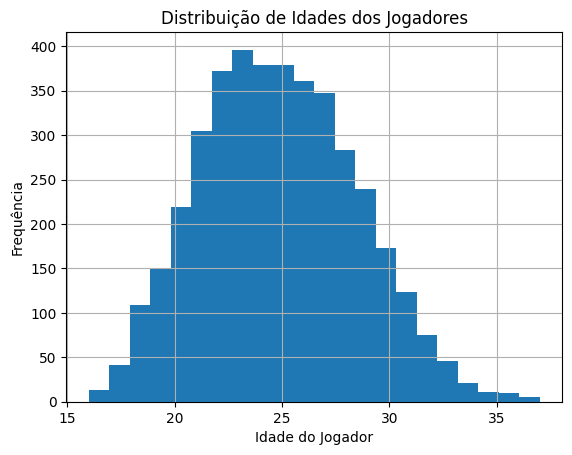

In [209]:
pl_transfers['playerAge'].hist(bins=22)
plt.xlabel('Idade do Jogador')
plt.ylabel('Frequência')
plt.title('Distribuição de Idades dos Jogadores')
plt.show()

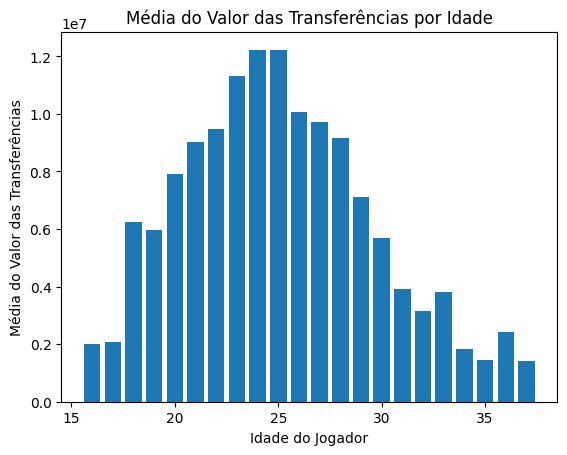

In [206]:
mean_transfer_fee_by_age = pl_transfers.groupby('playerAge')['transferFee'].mean()

plt.bar(mean_transfer_fee_by_age.index, mean_transfer_fee_by_age.values)
plt.xlabel('Idade do Jogador')
plt.ylabel('Média do Valor das Transferências')
plt.title('Média do Valor das Transferências por Idade')
plt.show()

Valor de mercado versus taxa de transferência: Você pode explorar a relação entre o valor de mercado atual do jogador e a taxa de transferência usando um gráfico de dispersão. Isso pode ajudar a identificar jogadores que foram transferidos por valores altos ou baixos em relação ao seu valor de mercado.

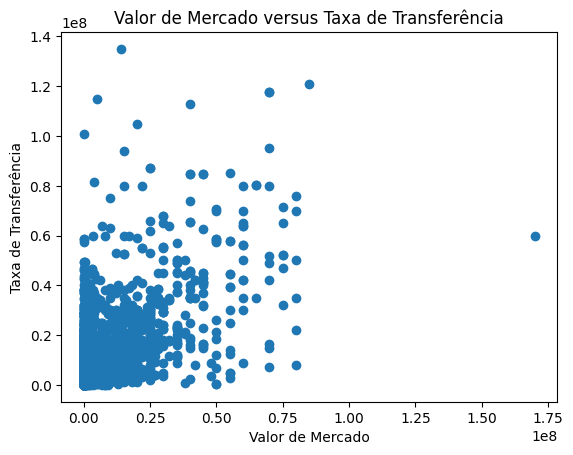

In [169]:
plt.scatter(pl_transfers['playerMarketValue'], pl_transfers['transferFee'])
plt.xlabel('Valor de Mercado')
plt.ylabel('Taxa de Transferência')
plt.title('Valor de Mercado versus Taxa de Transferência')
plt.show()

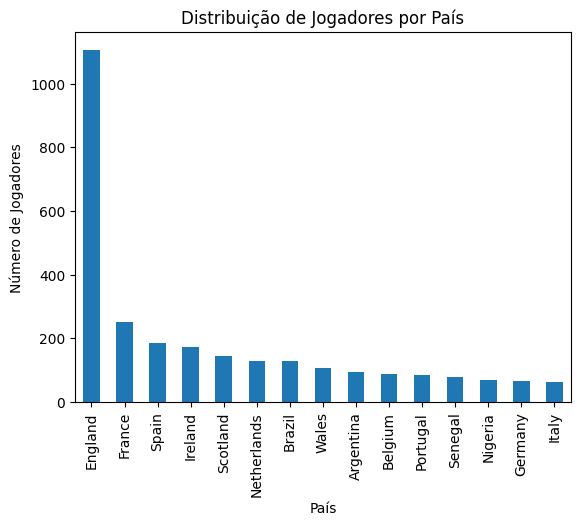

In [171]:
country_counts = pl_transfers['playerCountry'].value_counts().head(15)
country_counts.plot(kind='bar')
plt.xlabel('País')
plt.ylabel('Número de Jogadores')
plt.title('Distribuição de Jogadores por País')
plt.show()

Top 15 sem inglaterra

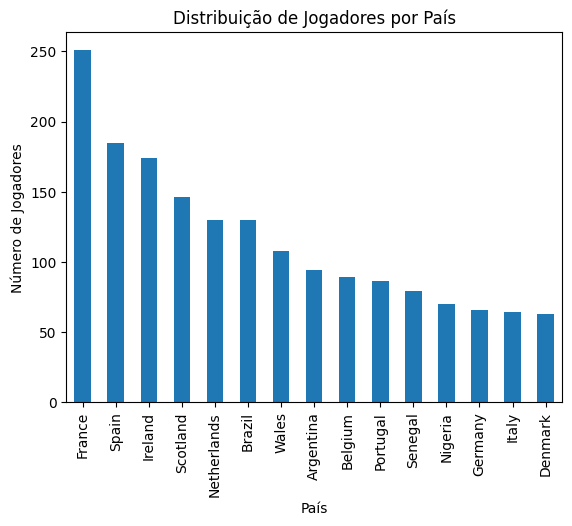

In [175]:
country_counts = pl_transfers['playerCountry'].value_counts().head(16).tail(15)
country_counts.plot(kind='bar')
plt.xlabel('País')
plt.ylabel('Número de Jogadores')
plt.title('Distribuição de Jogadores por País')
plt.show()

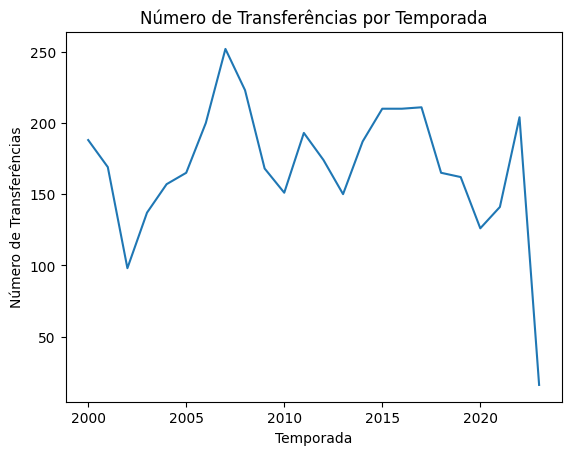

In [176]:
transfer_counts = pl_transfers['season'].value_counts().sort_index()
transfer_counts.plot(kind='line')
plt.xlabel('Temporada')
plt.ylabel('Número de Transferências')
plt.title('Número de Transferências por Temporada')
plt.show()

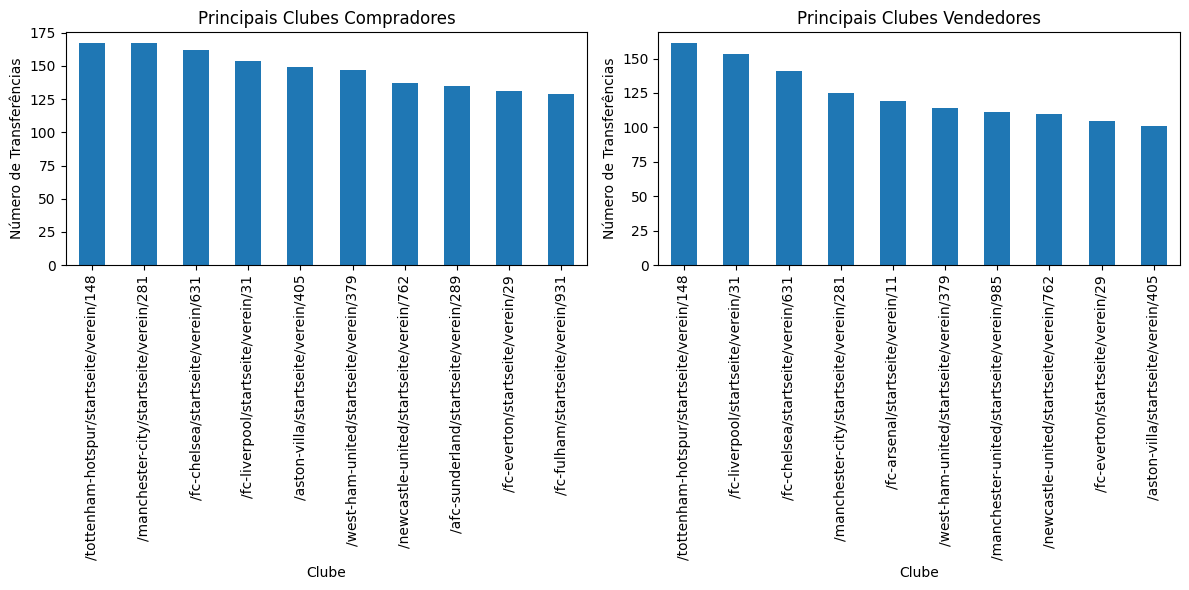

In [177]:
top_buyers = pl_transfers['clubJoined'].value_counts().nlargest(10)
top_sellers = pl_transfers['clubLeft'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
plt.subplot(121)
top_buyers.plot(kind='bar')
plt.xlabel('Clube')
plt.ylabel('Número de Transferências')
plt.title('Principais Clubes Compradores')

plt.subplot(122)
top_sellers.plot(kind='bar')
plt.xlabel('Clube')
plt.ylabel('Número de Transferências')
plt.title('Principais Clubes Vendedores')

plt.tight_layout()
plt.show()

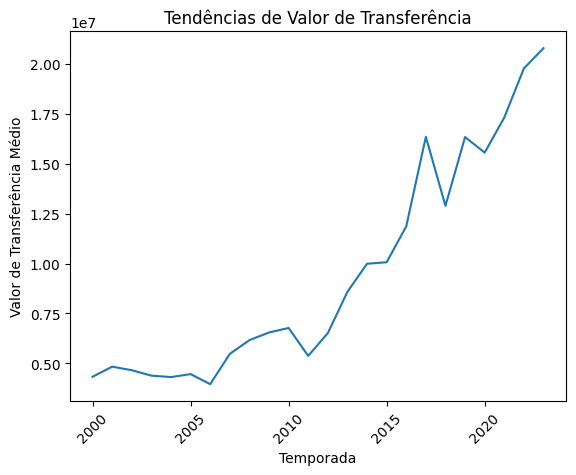

In [179]:
transfer_value_trends = pl_transfers.groupby('season')['transferFee'].mean()

plt.plot(transfer_value_trends.index, transfer_value_trends.values)
plt.xlabel('Temporada')
plt.ylabel('Valor de Transferência Médio')
plt.title('Tendências de Valor de Transferência')
plt.xticks(rotation=45)
plt.show()

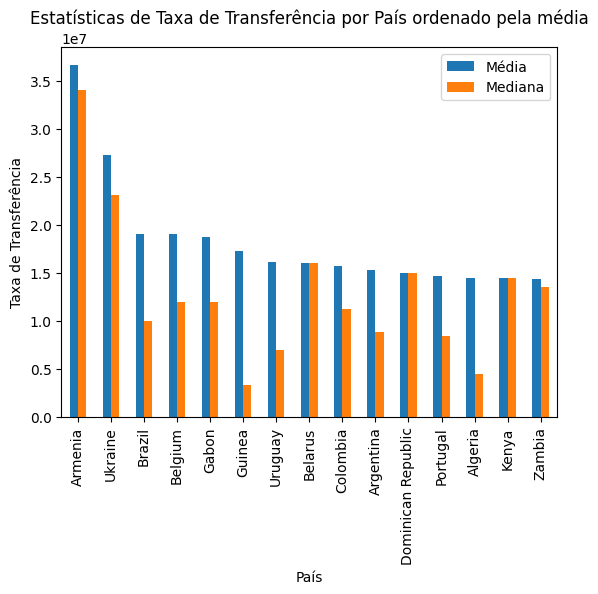

In [185]:
country_stats = pl_transfers.groupby('playerCountry')['transferFee'].agg(['mean', 'median'])
top_countries = country_stats.nlargest(15, 'mean')

top_countries.plot(kind='bar')
plt.xlabel('País')
plt.ylabel('Taxa de Transferência')
plt.title('Estatísticas de Taxa de Transferência por País ordenado pela média')
plt.legend(['Média', 'Mediana'])
plt.show()

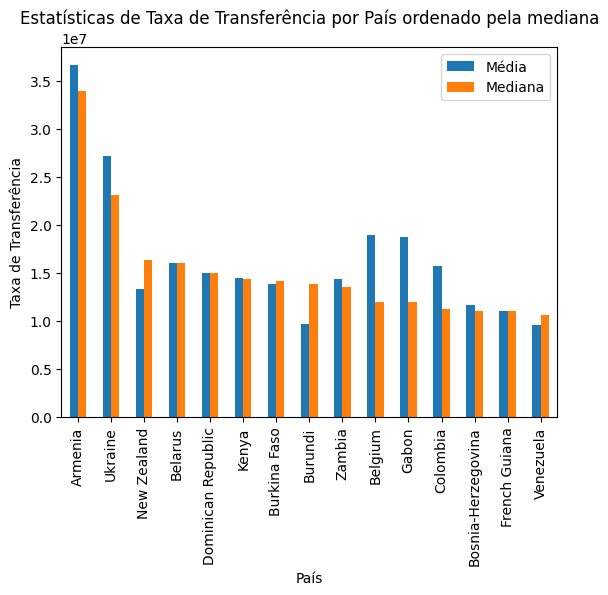

In [186]:
country_stats = pl_transfers.groupby('playerCountry')['transferFee'].agg(['mean', 'median'])
top_countries = country_stats.nlargest(15, 'median')

top_countries.plot(kind='bar')
plt.xlabel('País')
plt.ylabel('Taxa de Transferência')
plt.title('Estatísticas de Taxa de Transferência por País ordenado pela mediana')
plt.legend(['Média', 'Mediana'])
plt.show()

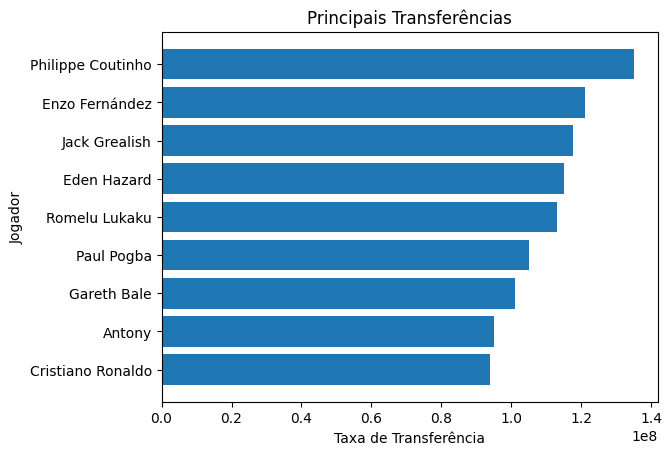

In [187]:
top_transfers = pl_transfers.nlargest(10, 'transferFee')

plt.barh(top_transfers['playerName'], top_transfers['transferFee'])
plt.xlabel('Taxa de Transferência')
plt.ylabel('Jogador')
plt.title('Principais Transferências')
plt.gca().invert_yaxis()
plt.show()

/tmp/ipykernel_177288/3143846198.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


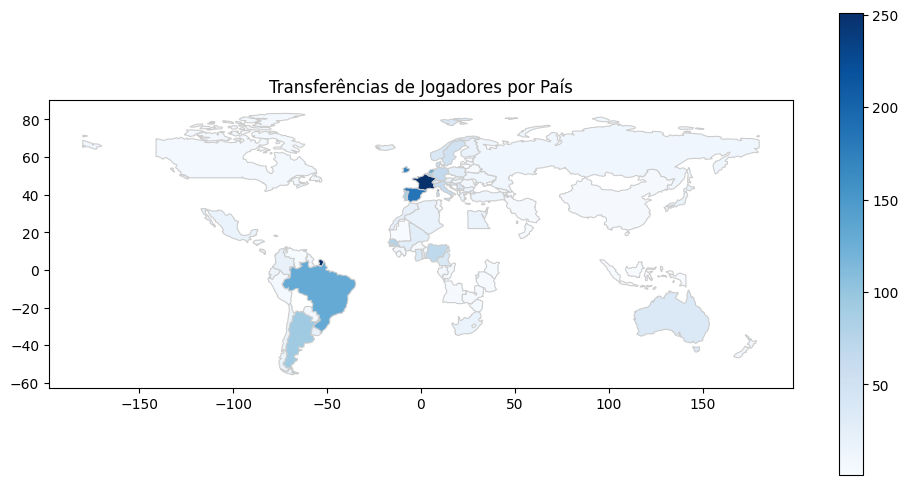

In [189]:
import geopandas as gpd

# Carregar arquivo shapefile com os dados geográficos dos países
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Calcular o número de transferências por país
transfer_counts = pl_transfers['playerCountry'].value_counts()
transfer_counts = transfer_counts.reset_index()
transfer_counts.columns = ['country', 'transfer_count']

# Mesclar dados geográficos com dados de transferências
merged_data = world.merge(transfer_counts, left_on='name', right_on='country', how='left')

# Plotar o mapa de transferências
fig, ax = plt.subplots(figsize=(12, 6))
merged_data.plot(column='transfer_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Transferências de Jogadores por País')
plt.show()

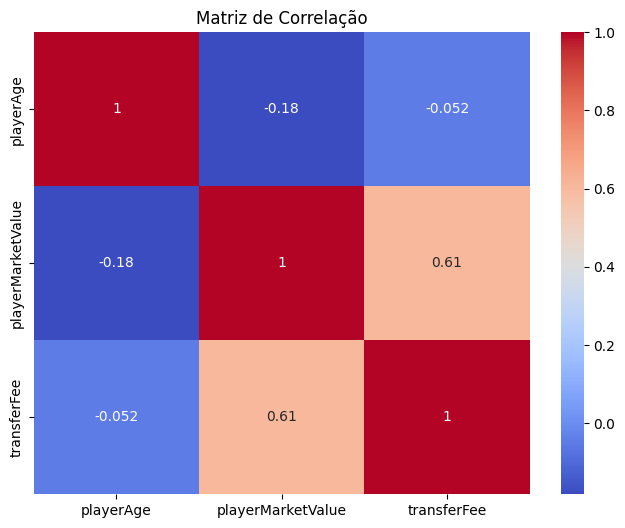

In [216]:
correlation_matrix = pl_transfers[['playerAge', 'playerMarketValue', 'transferFee']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

# Pré-processamento dos dados
Nesta seção realizaremos o tratamento dos dados, removendo outliers, normalizando, padronizando e transformando os dados

# Construção do modelo
Nesta seção abordaremos a construção de um modelo de precificação dos jogadores

## Divisão dos dados
Nessa subseção iremos separar os dados em um conjunto de treinamento e um conjunto de teste